# Adaptation Evaluation

This dataframe explores the effect of the simple adaitation controller implemented in this scenario.
This is done by comparing the prediction quality and time with and without adaptation.

In [1]:
# set working directoy to root directory of the project
if not "working_directory_corrected" in vars():
    %cd ..
    %cd ..
    %cd ..
    working_directory_corrected = True
    
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

from examples.simple_scenario.src.simple_scenario import create_simple_scenario

c:\Users\frank\Documents\Research\projects\evohome\environment\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


c:\Users\frank\Documents\Research\projects\evohome\examples\simple_scenario
c:\Users\frank\Documents\Research\projects\evohome\examples
c:\Users\frank\Documents\Research\projects\evohome


## Data Loading

Below we load the data. We load the following datasets:
- data/running.pickle
- data/adapting.pickle

Both datasets have the same structure as described in data_exploration.ipynb.

Additional data processing:
- For look-ahead scenarios the first few predicted values are typically NaN values. We drop them from the dataset.
- We convert predictions to type integer (booleans are represented as 0 = false, 1 = true)
- We convert date into datetime type and set it to be the index of the data frame

In [2]:
def load_data(file):
    data_frame = pd.read_pickle(file)
    data_frame.dropna(axis = 0, how = "any", inplace = True)
    for index in range(nr_rooms):
        column = "prediction_" + str(index)
        data_frame[column] = data_frame[column].astype('int32')
    data_frame["date"] = pd.to_datetime(data_frame["date"])
    data_frame.set_index(pd.DatetimeIndex(data_frame["date"]), inplace=True)
    data_frame.drop("date", axis = 1, inplace= True)
    return data_frame

scenario = create_simple_scenario()
room_names = scenario.get_room_names()
nr_rooms = len(room_names)

data_frame_static = load_data("examples/simple_scenario/data/running.pickle")
data_frame_adaptive = load_data("examples/simple_scenario/data/adapting.pickle")

data_frame_adaptive


,weather,prediction_time,adaptation_time,room_0,prediction_0,room_1,prediction_1,room_2,prediction_2,room_3,...,prediction_7,room_8,prediction_8,room_9,prediction_9,room_10,prediction_10,weekday,hour,minute
date,,,,,,,,,,,,,,,,,,,,,
2020-06-06 01:01:00,0.556511,0.000408,0.000524,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,5,1,1
2020-06-06 01:02:00,0.566788,0.000408,0.000524,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,5,1,2
2020-06-06 01:03:00,0.577069,0.000112,0.000258,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,5,1,3
2020-06-06 01:04:00,0.567354,0.000095,0.000238,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,5,1,4
2020-06-06 01:05:00,0.557644,0.000090,0.000999,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,5,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-26 23:56:00,0.272289,0.000102,0.000237,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,3,23,56
2022-05-26 23:57:00,0.262274,0.000104,0.000231,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,3,23,57
2022-05-26 23:58:00,0.252263,0.000104,0.000243,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,3,23,58


## Score Development

Below we split the dataset into days and calculate per room and average scores for each day.
As score we use the F1 score, where the positive class is presence in a room.

In [3]:
def get_f1(data_frame):
    f1s = []
    for index in range(nr_rooms):
        f1s.append(metrics.f1_score(y_pred = data_frame["prediction_" + str(index)], 
                                                 y_true = data_frame["room_" + str(index)],
                                                 zero_division = 0))
    return f1s

def to_day_scores(data_frame):
    by_day_data = data_frame.groupby(data_frame.index.date)
    days = [group[0] for group in by_day_data]
    day_scores = [get_f1(group[1]) for group in by_day_data]
    day_scores = pd.DataFrame(day_scores, index=pd.DatetimeIndex(days))
    day_scores["average"] = day_scores[0]
    for index in range(1,nr_rooms):
        day_scores["average"] += day_scores[index]
    day_scores["average"] /= nr_rooms
    return day_scores

day_scores_static = to_day_scores(data_frame_static)
day_scores_adaptive = to_day_scores(data_frame_adaptive)



We now visualize the average accuracy per day.
The visualized time frame can be adjusted by changint start and end date. 
Minimum and maximum date can be read from the above dataframe visualization

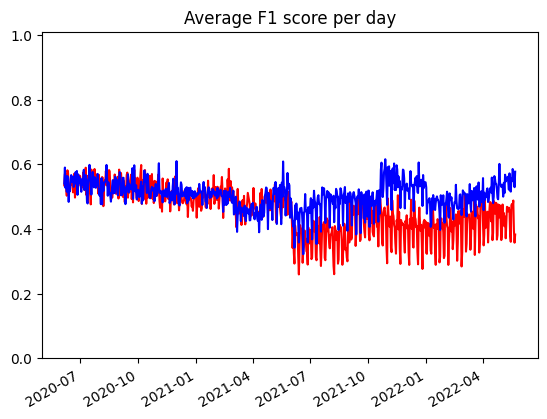

In [4]:

start_date = datetime(year = 2020,month=6, day = 1)
end_date = datetime(year = 2022,month=5, day = 22)

fig, ax = plt.subplots()
ax.plot(day_scores_static[start_date:end_date]["average"],"r-")
ax.plot(day_scores_adaptive[start_date:end_date]["average"],"b-")
ax.set_title("Average F1 score per day")
ax.set_ylim([0.0, 1.01])
fig.autofmt_xdate()
plt.show()

Next we visualize the accuracy per room.

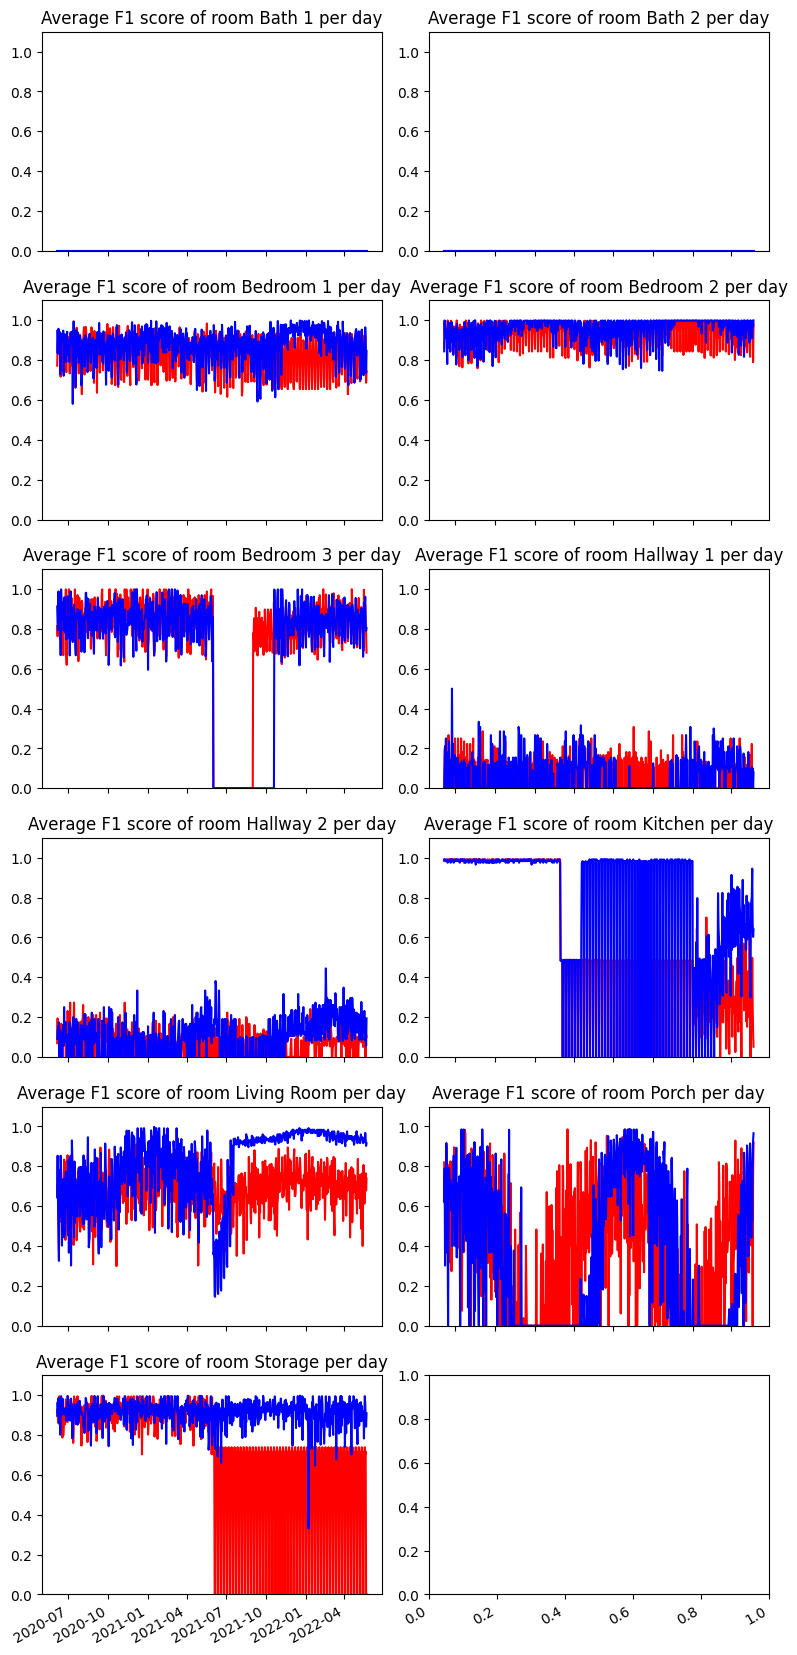

In [5]:
start_date = datetime(year = 2020,month=6, day = 1)
end_date = datetime(year = 2022,month=5, day = 22)

nr_cols = 2

fig, subplots = plt.subplots(ncols= nr_cols,nrows= (nr_rooms+1) //nr_cols, figsize = (8,20))

for room_index in range(nr_rooms):
    ax = subplots[room_index//nr_cols][room_index% nr_cols]
    ax.set_title(f"Average F1 score of room {room_names[room_index]} per day")
    ax.plot(day_scores_static[start_date:end_date][room_index],"r-")
    ax.plot(day_scores_adaptive[start_date:end_date][room_index],"b-")
    ax.set_ylim([0, 1.1])
    
fig.tight_layout()
fig.autofmt_xdate()
plt.show()

## Prediction Time development

Below we plot the prediction time development over the scenario period.

Overall adaptation time: 284.0234004796366 s
Maximum Adaptation time:  0.5391385999973863 s
Minimum Adaptation time:  0.00019890000112354755 s
Average Adaptation time:  0.0002739581770546488 s


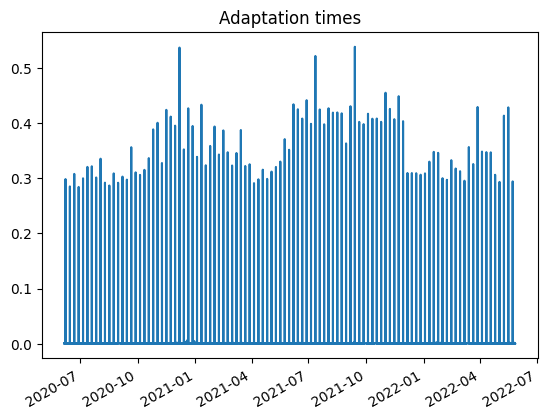

In [6]:

overall_time = data_frame_adaptive["adaptation_time"].sum()
max_time = data_frame_adaptive["adaptation_time"].max()
min_time = data_frame_adaptive["adaptation_time"].min()
average_time = data_frame_adaptive["adaptation_time"].mean()

print("Overall adaptation time:", overall_time, "s")
print("Maximum Adaptation time: ", max_time, "s")
print("Minimum Adaptation time: ", min_time, "s")
print("Average Adaptation time: ", average_time, "s")

start_date = datetime(year = 2020,month=6, day = 1)
end_date = datetime(year = 2022,month=5, day = 22)

fig, ax = plt.subplots()
ax.plot(data_frame_adaptive["adaptation_time"])
ax.set_title("Adaptation times")
#ax.set_ylim([0.0, 1])
fig.autofmt_xdate()
plt.show()